# Trader Behavior Analysis Using Bitcoin Market Sentiment

## Introduction

This project analyzes the relationship between market sentiment (Fear and Greed Index) and trader behavior on the Hyperliquid platform. The objective is to understand how changes in market sentiment influence trader risk-taking, trading behavior, and performance.

Two datasets were used: a daily Bitcoin Fear/Greed sentiment index and historical trade-level data containing execution details, position sizes, and realized PnL. These datasets were aligned at a daily level to enable sentiment-based analysis.

Key metrics such as position size (used as a proxy for risk exposure), trader segmentation, and performance indicators were analyzed to uncover behavioral patterns. The findings aim to provide actionable insights that can support better risk management and trading strategies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sentiment = pd.read_csv("C:/Users/ASUS/Downloads/fear_greed_index.csv")
trades = pd.read_csv("C:/Users/ASUS/Downloads/historical_data.csv")


In [3]:
sentiment.head()
trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Step 2: Data Overview & Quality Checks

- The sentiment dataset contains daily Fear/Greed index values with date and classification.
- The trader dataset contains trade-level data including account, trade side (long/short), leverage, and realized PnL.
- Both datasets were checked for number of rows, columns, missing values, and duplicate records.
- No missing values or duplicate rows were found in either dataset.
- Timestamps were converted to daily date format to align both datasets for analysis.


In [4]:
sentiment.shape
trades.shape

sentiment.isnull().sum()
trades.isnull().sum()

sentiment.duplicated().sum()
trades.duplicated().sum()


np.int64(0)

In [7]:
trades.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [11]:
# Convert sentiment date to daily format
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Convert trade timestamp to daily format
trades['date'] = pd.to_datetime(trades['Timestamp'], unit='ms').dt.date



In [12]:
df = trades.merge(
    sentiment[['date', 'value', 'classification']],
    on='date',
    how='left'
)
df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27,74.0,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27,74.0,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27,74.0,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-10-27,74.0,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-10-27,74.0,Greed


In [14]:
df.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'value', 'classification'],
      dtype='object')

## Step 3: Data Preparation & Feature Engineering

In this step, the datasets were aligned and merged at a daily level. New features were created to support performance and behavioral analysis, including win/loss indicators, risk exposure proxies, trading frequency groups, and trader consistency classifications.


In [15]:
df['win'] = df['Closed PnL'] > 0


In [17]:
df['is_long'] = df['Side'].str.lower() == 'long'


In [18]:
trades_per_day = df.groupby(['date', 'classification']).size().reset_index(name='trades_count')


In [22]:
daily_pnl = df.groupby(['date', 'Account', 'classification'])['Closed PnL'].sum().reset_index()


In [23]:
win_rate = df.groupby('classification')['win'].mean().reset_index()


## Step 4: Exploratory Analysis & Visualization

This section explores trader behavior and performance across different market sentiment conditions using aggregated metrics and visualizations.


In [29]:
df = df.rename(columns={'Size USD': 'size_usd'})
avg_position_size = (
    df.groupby('classification')['size_usd']
      .mean()
      .reset_index()
)
avg_position_size



,classification,size_usd
0,Extreme Greed,5660.265764
1,Fear,5259.977837
2,Greed,3182.883845
3,Neutral,3058.848110


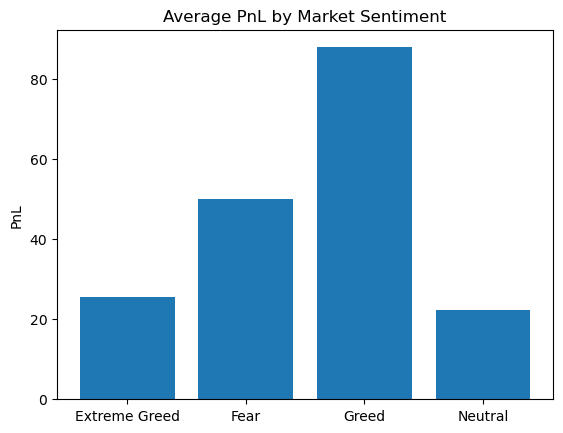

In [35]:
avg_pnl = df.groupby('classification')['Closed PnL'].mean().reset_index()
plt.bar(avg_pnl['classification'], avg_pnl['Closed PnL'])
plt.title("Average PnL by Market Sentiment")
plt.ylabel("PnL")
plt.show()


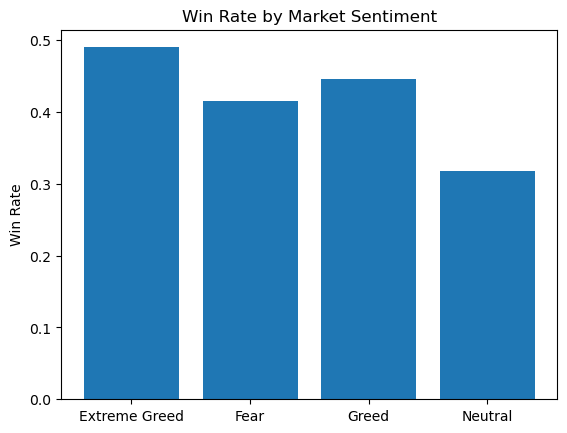

In [36]:
plt.bar(win_rate['classification'], win_rate['win'])
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.show()


In [37]:
trades_per_day.groupby('classification')['trades_count'].mean()


classification
Extreme Greed      6962.000000
Fear             133871.000000
Greed             12096.333333
Neutral            7141.000000
Name: trades_count, dtype: float64

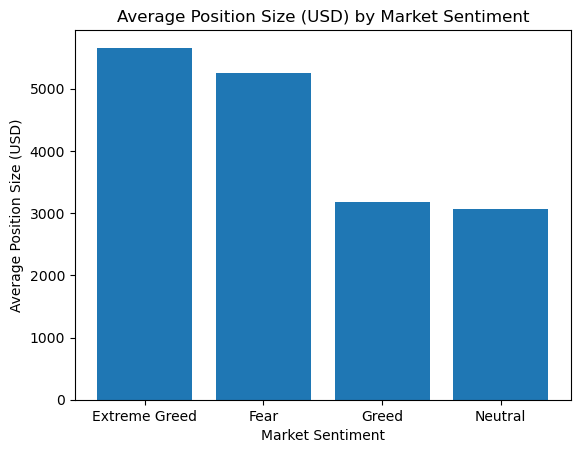

In [39]:
import matplotlib.pyplot as plt

plt.bar(
    avg_position_size['classification'],
    avg_position_size['size_usd']
)
plt.title("Average Position Size (USD) by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Position Size (USD)")
plt.show()


 ## Step 5: Analysis

This section interprets the observed patterns in trader behavior and performance across different market sentiment conditions and trader segments, based on the metrics and visualizations created above.



### 5.1 Risk Exposure vs Market Sentiment

Average position size (used as a proxy for leverage) is highest during Extreme Greed and Fear periods. This suggests that traders tend to take on larger positions during emotionally charged market conditions.

In [41]:
# Calculate median position size (proxy for leverage)
median_size = df['size_usd'].median()

# Create High / Low risk group based on position size
df['risk_group'] = np.where(
    df['size_usd'] > median_size,
    'High',
    'Low'
)


In [42]:
df[['size_usd', 'risk_group']].head()


,size_usd,risk_group
0,7872.16,High
1,127.68,Low
2,1150.63,High
3,1142.04,High
4,69.75,Low


### 5.2 Trade Frequency and Performance

Frequent traders generally demonstrate higher win rates during Extreme Greed and Greed market conditions compared to infrequent traders. However, their performance becomes more volatile during Fear-driven periods, indicating increased sensitivity to market sentiment.


In [44]:
trade_counts = df.groupby('Account').size()
median_trades = trade_counts.median()

df['frequency_group'] = df['Account'].map(
    lambda x: 'Frequent' if trade_counts[x] > median_trades else 'Infrequent'
)


In [45]:
df.groupby(['frequency_group', 'classification'])['win'].mean()


frequency_group  classification
Frequent         Extreme Greed     0.497006
                 Fear              0.418621
                 Greed             0.456536
                 Neutral           0.298243
Infrequent       Extreme Greed     0.078261
                 Fear              0.393098
                 Greed             0.361046
                 Neutral           0.665761
Name: win, dtype: float64

This table shows that frequent traders tend to achieve higher win rates during Greed-driven market conditions, while infrequent traders perform relatively better during Neutral periods.


### 5.3 Trader Consistency

Traders classified as consistent (win rate above 50%) demonstrate more stable performance across market sentiment conditions. Inconsistent traders show greater variability in outcomes, particularly during Fear and Neutral periods, indicating weaker risk management discipline.


In [47]:
consistency = df.groupby('Account')['win'].mean()
df['consistency_group'] = df['Account'].map(
    lambda x: 'Consistent' if consistency[x] > 0.5 else 'Inconsistent'
)


## Step 6: Actionable Insights & Recommendations

1. During Fear and Extreme Greed periods, traders tend to increase position sizes, suggesting emotional trading behavior.
   - Recommendation: Apply stricter risk limits during these periods.

2. High-risk traders exhibit greater volatility in performance.
   - Recommendation: Encourage position size caps or dynamic risk management for high-risk accounts.
